# **Module 1 fitting code**

CSV 파일들을 선택해 업로드하세요 (여러 개 가능).


Saving M1_215_internalad3.csv to M1_215_internalad3 (1).csv


,fname,case,c_mohm,kx,ky,kz,n,mean,std,vth
0,M1_215_internalad3 (1).csv,"(1,1,1)",2.666667,1,1,1,5000,0.205827,0.005146,0.530654


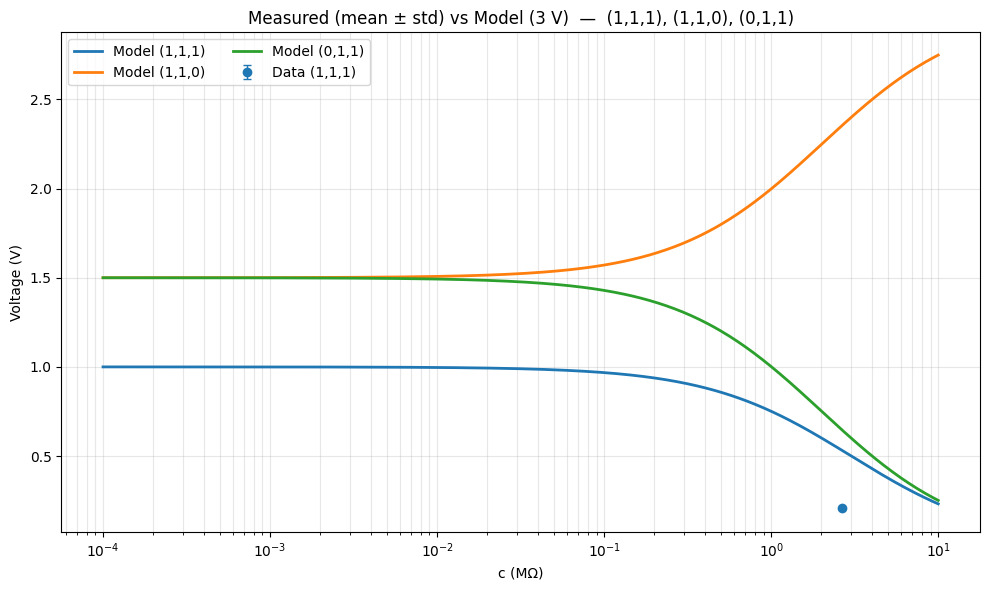

In [ ]:
# @title Data vs. Model (3V) plotter for M1_*_internalad3 CSVs (Colab) with case filter
# 업로드할 CSV 파일명 형식:
#   M1_<zyx>[_<mult>][ohm]_internalad3*.csv
#   <zyx>는 (z,y,x) 자리수(0~9), <mult> 없으면 1e6 Ω, 정수면 그 값 Ω, '100k'면 1e5 Ω

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from io import StringIO
from typing import Optional, Dict, Tuple
from google.colab import files

ALLOWED_CASES = {"(1,1,1)","(1,1,0)","(0,1,1)"}  # 이외는 데이터 포인트 제외

# ---------- Model (inputs in MΩ); experiment used 3 V ----------
def volt2_unit1V(x_mohm: float, y_mohm: float, z_mohm: float) -> float:
    R_1n = 1.005; R_1p = 1.005
    if x_mohm + R_1n == 0: return np.nan
    R_eq1n = (x_mohm * R_1n) / (x_mohm + R_1n)
    denom = R_eq1n + y_mohm + R_1p
    if denom == 0: return np.nan
    R_eq1p = ((R_eq1n + y_mohm) * R_1p) / denom
    if (R_eq1p + z_mohm) == 0 or (R_eq1n + y_mohm) == 0: return np.nan
    return float((R_eq1p/(R_eq1p+z_mohm)) * (y_mohm/(R_eq1n+y_mohm)))

def volt2_3V(x_mohm: float, y_mohm: float, z_mohm: float) -> float:
    return 3.0 * volt2_unit1V(x_mohm, y_mohm, z_mohm)

# ---------- Filename parsing ----------
FNAME_RE = re.compile(r'^M1_(\d{3})(?:_([\d]+[kKmMgG]?))?(?:ohm)?_internalad3.*\.csv$', re.IGNORECASE)

def parse_multiplier(token: Optional[str]) -> float:
    if not token: return 1e6
    m = re.fullmatch(r'(\d+)([kKmMgG]?)', token.strip())
    if not m: raise ValueError(f"Bad multiplier token: {token}")
    v = int(m.group(1)); s = m.group(2).lower()
    if   s == 'k': v *= 1e3
    elif s == 'm': v *= 1e6
    elif s == 'g': v *= 1e9
    return float(v)

def classify_case(xd:int, yd:int, zd:int) -> Optional[str]:
    if xd>0 and yd>0 and zd>0: return "(1,1,1)"
    if xd==0 and yd>0 and zd>0: return "(1,1,0)"
    if xd>0 and yd>0 and zd==0: return "(0,1,1)"
    return None

def parse_file_meta(fname: str) -> Optional[Dict]:
    m = FNAME_RE.match(fname)
    if not m: return None
    zyx, mult_tok = m.group(1), m.group(2)
    zd, yd, xd = int(zyx[0]), int(zyx[1]), int(zyx[2])
    case = classify_case(xd, yd, zd)
    if case is None:
        print(f"[SKIP] 대상 케이스 아님: {fname}  (digits z,y,x= {zd},{yd},{xd})")
        return None
    mult_ohm = parse_multiplier(mult_tok)  # Ω
    # c 정의: 비의 '1'에 해당하는 실값(Ω) 평균으로 산출
    digits = {"(1,1,1)":[xd, yd, zd], "(1,1,0)":[yd, zd], "(0,1,1)":[xd, yd]}[case]
    c_ohm  = float(np.mean([d*mult_ohm for d in digits]))
    c_mohm = c_ohm / 1e6
    # 비 (kx,ky,kz)
    if case == "(1,1,1)": kx,ky,kz = 1,1,1
    elif case == "(1,1,0)": kx,ky,kz = 0,1,1   # x=0
    else: kx,ky,kz = 1,1,0                      # z=0
    return dict(fname=fname, case=case, c_mohm=c_mohm, kx=kx, ky=ky, kz=kz)

# ---------- Data loading (2nd column) ----------
def read_voltage_col2_from_bytes(b: bytes) -> Tuple[float,float,int]:
    for header_none in (True, False):
        try:
            df = pd.read_csv(StringIO(b.decode('utf-8')), header=None if header_none else 'infer')
        except Exception:
            continue
        if df.shape[1] >= 2:
            s = pd.to_numeric(df.iloc[:,1], errors='coerce').dropna()
            if not s.empty:
                mu = float(s.mean())
                sd = float(s.std(ddof=1)) if len(s)>1 else 0.0
                return (mu, sd, int(len(s)))
    return (np.nan, np.nan, 0)

# ---------- Upload & process (filtering to ALLOWED_CASES) ----------
print("CSV 파일들을 선택해 업로드하세요 (여러 개 가능).")
uploaded = files.upload()  # {filename: bytes}

rows = []
for fname, b in uploaded.items():
    meta = parse_file_meta(fname)
    if not meta:
        continue  # 형식 불일치 or 대상 케이스 아님
    if meta["case"] not in ALLOWED_CASES:
        print(f"[SKIP] 허용되지 않는 케이스: {fname}  ({meta['case']})")
        continue
    mean_v, std_v, n = read_voltage_col2_from_bytes(b)
    x, y, z = meta["kx"]*meta["c_mohm"], meta["ky"]*meta["c_mohm"], meta["kz"]*meta["c_mohm"]
    v_th = volt2_3V(x, y, z)
    rows.append({**meta, "n":n, "mean":mean_v, "std":std_v, "vth":v_th})

if not rows:
    raise SystemExit("유효한 CSV(허용 케이스)가 없습니다. 파일명을 규칙에 맞춰주세요.")

df = pd.DataFrame(rows).sort_values(["case","c_mohm"]).reset_index(drop=True)
display(df)

# ---------- Plot (single figure) ----------
COLORS = {"(1,1,1)":"tab:blue","(1,1,0)":"tab:orange","(0,1,1)":"tab:green"}

fig, ax = plt.subplots(figsize=(10,6))

# 이론곡선: c in [1e-4, 10] MΩ 이론 곡선은 (x,y,z)notation 을 그대로
cgrid = np.logspace(-4, 1, 400)
for case in ["(1,1,1)", "(1,1,0)", "(0,1,1)"]:
    if case == "(1,1,1)":
        xg, yg, zg = cgrid, cgrid, cgrid
    elif case == "(1,1,0)":
        xg, yg, zg = cgrid, cgrid, 0*cgrid
    else: #"(0,1,1)"
        xg, yg, zg = 0*cgrid, cgrid, cgrid
    vg = np.array([volt2_3V(xi, yi, zi) for xi,yi,zi in zip(xg,yg,zg)])
    ax.plot(cgrid, vg, color=COLORS[case], linewidth=2, label=f"Model {case}")

# 데이터 포인트(오차막대) — ALLOWED_CASES에 해당하는 것만
for case, g in df.groupby("case"):
    if case not in ALLOWED_CASES:  # 안전장치
        continue
    ax.errorbar(g["c_mohm"], g["mean"], yerr=g["std"], fmt='o',
                ms=6, capsize=3, elinewidth=1.0, color=COLORS[case],
                label=f"Data {case}")

ax.set_xscale("log")
ax.set_xlabel("c (MΩ)")
ax.set_ylabel("Voltage (V)")
ax.set_title("Measured (mean ± std) vs Model (3 V)  —  (1,1,1), (1,1,0), (0,1,1)")
ax.grid(True, which="both", alpha=0.3)
ax.legend(ncol=2)
plt.tight_layout()
plt.show()


# **skip 코드 추가**

CSV 파일들을 선택해 업로드하세요 (여러 개 가능).


Saving M1_011_1k_internalad3.csv to M1_011_1k_internalad3 (1).csv
Saving M1_011_10k_internalad3.csv to M1_011_10k_internalad3 (1).csv
Saving M1_011_100k_internalad3.csv to M1_011_100k_internalad3 (1).csv
Saving M1_011_200ohm_internalad3.csv to M1_011_200ohm_internalad3 (1).csv
Saving M1_011_internalad3.csv to M1_011_internalad3 (1).csv
Saving M1_012_internalad3.csv to M1_012_internalad3 (1).csv
Saving M1_021_internalad3.csv to M1_021_internalad3 (1).csv
Saving M1_022_1k_internalad3.csv to M1_022_1k_internalad3 (1).csv
Saving M1_022_10k_internalad3.csv to M1_022_10k_internalad3 (1).csv
Saving M1_022_100k_internalad3.csv to M1_022_100k_internalad3 (1).csv
Saving M1_022_200ohm_internalad3.csv to M1_022_200ohm_internalad3 (1).csv
Saving M1_022_internalad3.csv to M1_022_internalad3 (1).csv
Saving M1_033_1k_internalad3.csv to M1_033_1k_internalad3 (1).csv
Saving M1_033_10k_internalad3.csv to M1_033_10k_internalad3 (1).csv
Saving M1_033_100k_internalad3.csv to M1_033_100k_internalad3 (1).csv


,fname,case,c_mohm,kx,ky,kz,n,mean,std,vth
0,M1_011_200ohm_internalad3 (1).csv,"(0,1,1)",0.0002,0,1,1,5000,1.532148,0.001381,1.499851
1,M1_022_200ohm_internalad3 (1).csv,"(0,1,1)",0.0004,0,1,1,5000,1.513929,0.001297,1.499702
2,M1_033_200ohm_internalad3 (1).csv,"(0,1,1)",0.0006,0,1,1,5000,1.510009,0.001238,1.499552
3,M1_044_200ohm_internalad3 (1).csv,"(0,1,1)",0.0008,0,1,1,5000,1.509213,0.001238,1.499403
4,M1_011_1k_internalad3 (1).csv,"(0,1,1)",0.0010,0,1,1,5000,1.495559,0.001205,1.499254
...,...,...,...,...,...,...,...,...,...,...
84,M1_333_internalad3 (1).csv,"(1,1,1)",3.0000,1,1,1,5000,0.512303,0.002621,0.501247
85,M1_444_internalad3 (1).csv,"(1,1,1)",4.0000,1,1,1,5000,0.439817,0.002570,0.429793
86,M1_555_internalad3 (1).csv,"(1,1,1)",5.0000,1,1,1,5000,0.386365,0.008189,0.376170
87,M1_666_internalad3 (1).csv,"(1,1,1)",6.0000,1,1,1,5000,0.344944,0.003393,0.334443


------ Skip logs ------
[SKIP] 비율 불일치: M1_012_internalad3 (1).csv  (digits z,y,x= 0,1,2)
[SKIP] 비율 불일치: M1_021_internalad3 (1).csv  (digits z,y,x= 0,2,1)
[SKIP] 비율 불일치: M1_215_internalad3 (3).csv  (digits z,y,x= 2,1,5)
[SKIP] 비율 불일치: M1_221_internalad3 (1).csv  (digits z,y,x= 2,2,1)
Total skipped: 4


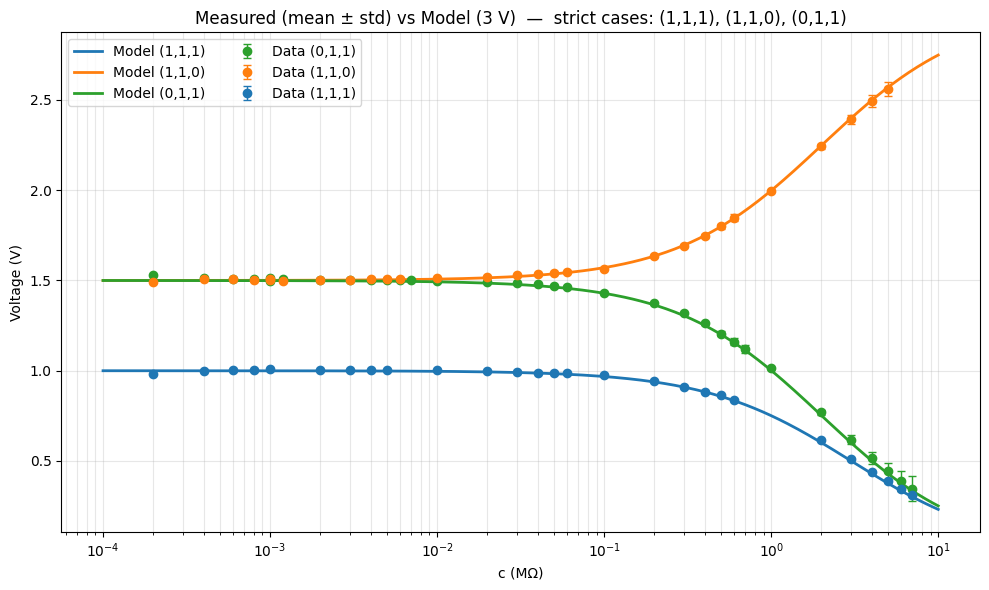

In [ ]:
# @title Data vs. Model (3V) plotter for M1_*_internalad3 CSVs (Colab) — strict ratio filter
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from io import StringIO
from typing import Optional, Dict, Tuple
from google.colab import files

ALLOWED_CASES = {"(1,1,1)","(1,1,0)","(0,1,1)"}  # 데이터 포인트로 허용되는 케이스

# ---------- Model (MΩ 입력), 실험은 3 V ----------
def volt2_unit1V(x_mohm: float, y_mohm: float, z_mohm: float) -> float:
    R_1n = 1.005; R_1p = 1.005
    if x_mohm + R_1n == 0: return np.nan
    R_eq1n = (x_mohm * R_1n) / (x_mohm + R_1n)
    denom = R_eq1n + y_mohm + R_1p
    if denom == 0: return np.nan
    R_eq1p = ((R_eq1n + y_mohm) * R_1p) / denom
    if (R_eq1p + z_mohm) == 0 or (R_eq1n + y_mohm) == 0: return np.nan
    return float((R_eq1p/(R_eq1p+z_mohm)) * (y_mohm/(R_eq1n+y_mohm)))

def volt2_3V(x_mohm: float, y_mohm: float, z_mohm: float) -> float:
    return 3.0 * volt2_unit1V(x_mohm, y_mohm, z_mohm)

# ---------- Filename parsing ----------
FNAME_RE = re.compile(r'^M1_(\d{3})(?:_([\d]+[kKmMgG]?))?(?:ohm)?_internalad3.*\.csv$', re.IGNORECASE)

def parse_multiplier(token: Optional[str]) -> float:
    if not token: return 1e6
    m = re.fullmatch(r'(\d+)([kKmMgG]?)', token.strip())
    if not m: raise ValueError(f"Bad multiplier token: {token}")
    v = int(m.group(1)); s = m.group(2).lower()
    if   s == 'k': v *= 1e3
    elif s == 'm': v *= 1e6
    elif s == 'g': v *= 1e9
    return float(v)

skip_logs = []

def classify_case_strict(xd:int, yd:int, zd:int) -> Optional[str]:
    # 엄격한 비율 체크: 동등성까지 검증
    if xd==yd==zd and xd>0:         return "(1,1,1)"
    if xd==0 and yd==zd and yd>0:   return "(1,1,0)"  # x=0, z=y>0
    if zd==0 and xd==yd and xd>0:   return "(0,1,1)"  # z=0, x=y>0
    return None

def parse_file_meta(fname: str) -> Optional[Dict]:
    m = FNAME_RE.match(fname)
    if not m:
        skip_logs.append(f"[SKIP] 파일명 형식 불일치: {fname}")
        return None
    zyx, mult_tok = m.group(1), m.group(2)
    zd, yd, xd = int(zyx[0]), int(zyx[1]), int(zyx[2])
    case = classify_case_strict(xd, yd, zd)
    if case is None:
        skip_logs.append(f"[SKIP] 비율 불일치: {fname}  (digits z,y,x= {zd},{yd},{xd})")
        return None
    mult_ohm = parse_multiplier(mult_tok)  # Ω
    # c: 비의 '1' 자리들의 실제 값 평균(세트가 모두 같으므로 평균=값)
    digits = {"(1,1,1)":[xd, yd, zd], "(1,1,0)":[yd, zd], "(0,1,1)":[xd, yd]}[case]
    c_ohm  = float(np.mean([d*mult_ohm for d in digits]))
    c_mohm = c_ohm / 1e6
    # 비 (kx,ky,kz) — 피팅 정의에 맞춤: (1,1,0)->(x=1,y=1,z=0), (0,1,1)->(x=0,y=1,z=1)
    if case == "(1,1,1)": kx,ky,kz = 1,1,1
    elif case == "(1,1,0)": kx,ky,kz = 1,1,0
    else:                   kx,ky,kz = 0,1,1
    return dict(fname=fname, case=case, c_mohm=c_mohm, kx=kx, ky=ky, kz=kz)

# ---------- Data loading (2nd column) ----------
def read_voltage_col2_from_bytes(b: bytes) -> Tuple[float,float,int]:
    for header_none in (True, False):
        try:
            df = pd.read_csv(StringIO(b.decode('utf-8')), header=None if header_none else 'infer')
        except Exception:
            continue
        if df.shape[1] >= 2:
            s = pd.to_numeric(df.iloc[:,1], errors='coerce').dropna()
            if not s.empty:
                mu = float(s.mean())
                sd = float(s.std(ddof=1)) if len(s)>1 else 0.0
                return (mu, sd, int(len(s)))
    return (np.nan, np.nan, 0)

# ---------- Upload & process ----------
print("CSV 파일들을 선택해 업로드하세요 (여러 개 가능).")
uploaded = files.upload()  # {filename: bytes}

rows = []
for fname, b in uploaded.items():
    meta = parse_file_meta(fname)
    if not meta:
        continue  # 형식/비율 불일치 → 스킵 로그에 기록됨
    mean_v, std_v, n = read_voltage_col2_from_bytes(b)
    x, y, z = meta["kx"]*meta["c_mohm"], meta["ky"]*meta["c_mohm"], meta["kz"]*meta["c_mohm"]
    v_th = volt2_3V(x, y, z)
    rows.append({**meta, "n":n, "mean":mean_v, "std":std_v, "vth":v_th})

if not rows:
    print("\n".join(skip_logs))
    raise SystemExit("유효한 CSV(허용 케이스)가 없습니다. 파일명을 규칙에 맞춰주세요.")

df = pd.DataFrame(rows).sort_values(["case","c_mohm"]).reset_index(drop=True)
display(df)

print("------ Skip logs ------")
if skip_logs:
    for line in skip_logs: print(line)
else:
    print("No skipped files.")
print(f"Total skipped: {len(skip_logs)}")

# ---------- Plot ----------
COLORS = {"(1,1,1)":"tab:blue","(1,1,0)":"tab:orange","(0,1,1)":"tab:green"}
fig, ax = plt.subplots(figsize=(10,6))

# 이론곡선: c ∈ [1e-4, 1e+1] MΩ — 피팅 정의에 맞춘 매핑
cgrid = np.logspace(-4, 1, 400)
for case in ["(1,1,1)", "(1,1,0)", "(0,1,1)"]:
    if case == "(1,1,1)":
        xg, yg, zg = cgrid, cgrid, cgrid
    elif case == "(1,1,0)":
        xg, yg, zg = cgrid, cgrid, 0*cgrid   # x=1,y=1,z=0
    else:  # "(0,1,1)"
        xg, yg, zg = 0*cgrid, cgrid, cgrid   # x=0,y=1,z=1
    vg = np.array([volt2_3V(xi, yi, zi) for xi,yi,zi in zip(xg,yg,zg)])
    ax.plot(cgrid, vg, color=COLORS[case], linewidth=2, label=f"Model {case}")

# 데이터 포인트(오차막대) — 허용 케이스만
for case, g in df.groupby("case"):
    ax.errorbar(g["c_mohm"], g["mean"], yerr=g["std"], fmt='o',
                ms=6, capsize=3, elinewidth=1.0, color=COLORS[case],
                label=f"Data {case}")

ax.set_xscale("log")
ax.set_xlabel("c (MΩ)")
ax.set_ylabel("Voltage (V)")
ax.set_title("Measured (mean ± std) vs Model (3 V)  —  strict cases: (1,1,1), (1,1,0), (0,1,1)")
ax.grid(True, which="both", alpha=0.3)
# 범례 중복 제거(혹시 중복 생성될 경우 대비)
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(uniq.values(), uniq.keys(), ncol=2)
plt.tight_layout()
plt.show()


# **R^2 값과 정규화**

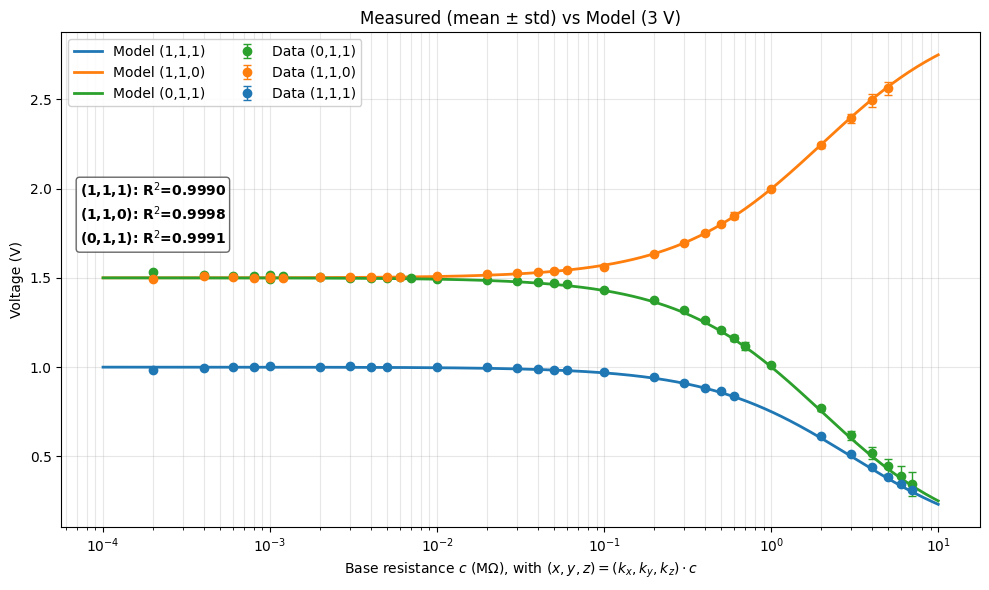

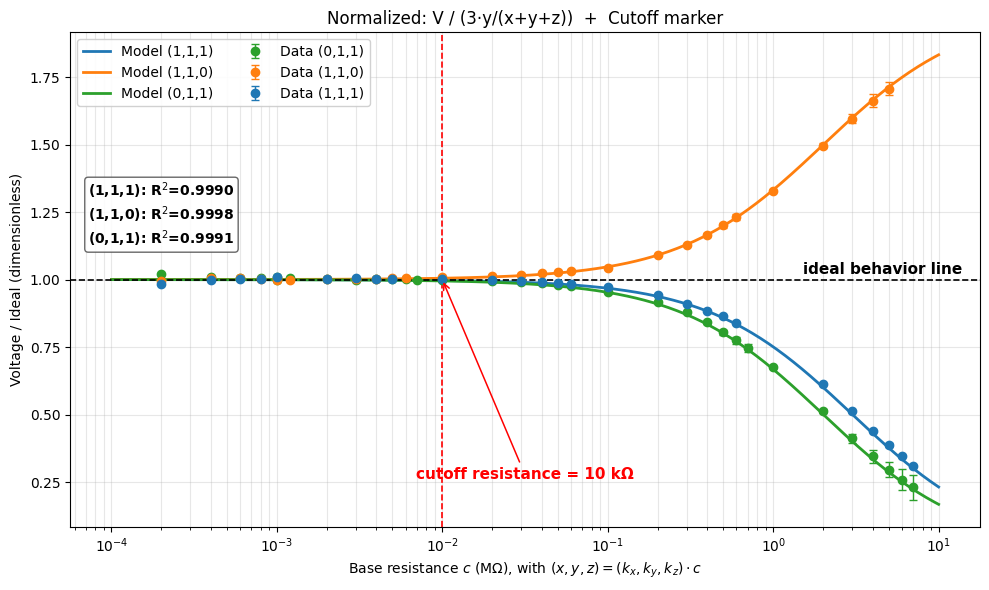

In [ ]:
# @title Data vs. Model (3V) — strict cases + per-case R² (raw & normalized) + cutoff marker + non-overlapping R² box
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from io import StringIO
from typing import Optional, Dict, Tuple
from google.colab import files

ALLOWED_CASES = {"(1,1,1)","(1,1,0)","(0,1,1)"}  # 허용 케이스만 데이터 포인트로 포함

# ---------- Model (입력: MΩ), 실험은 3 V ----------
def volt2_unit1V(x_mohm: float, y_mohm: float, z_mohm: float) -> float:
    R_1n = 1.005; R_1p = 1.005
    if x_mohm + R_1n == 0: return np.nan
    R_eq1n = (x_mohm * R_1n) / (x_mohm + R_1n)
    denom = R_eq1n + y_mohm + R_1p
    if denom == 0: return np.nan
    R_eq1p = ((R_eq1n + y_mohm) * R_1p) / denom
    if (R_eq1p + z_mohm) == 0 or (R_eq1n + y_mohm) == 0: return np.nan
    return float((R_eq1p/(R_eq1p+z_mohm)) * (y_mohm/(R_eq1n+y_mohm)))

def volt2_3V(x_mohm: float, y_mohm: float, z_mohm: float) -> float:
    return 3.0 * volt2_unit1V(x_mohm, y_mohm, z_mohm)

# ---------- Filename parsing ----------
FNAME_RE = re.compile(r'^M1_(\d{3})(?:_([\d]+[kKmMgG]?))?(?:ohm)?_internalad3.*\.csv$', re.IGNORECASE)

def parse_multiplier(token: Optional[str]) -> float:
    if not token: return 1e6
    m = re.fullmatch(r'(\d+)([kKmMgG]?)', token.strip())
    if not m: raise ValueError(f"Bad multiplier token: {token}")
    v = int(m.group(1)); s = m.group(2).lower()
    if   s == 'k': v *= 1e3
    elif s == 'm': v *= 1e6
    elif s == 'g': v *= 1e9
    return float(v)

skip_logs = []

# 엄격한 비율 판정: 정확히 (1,1,1)/(1,1,0)/(0,1,1)만 허용
def classify_case_strict(xd:int, yd:int, zd:int) -> Optional[str]:
    if xd==yd==zd and xd>0:         return "(1,1,1)"
    if xd==0 and yd==zd and yd>0:   return "(1,1,0)"  # x=0, z=y
    if zd==0 and xd==yd and xd>0:   return "(0,1,1)"  # z=0, x=y
    return None

def parse_file_meta(fname: str) -> Optional[Dict]:
    m = FNAME_RE.match(fname)
    if not m:
        skip_logs.append(f"[SKIP] 파일명 형식 불일치: {fname}")
        return None
    zyx, mult_tok = m.group(1), m.group(2)
    zd, yd, xd = int(zyx[0]), int(zyx[1]), int(zyx[2])
    case = classify_case_strict(xd, yd, zd)
    if case is None:
        skip_logs.append(f"[SKIP] 비율 불일치: {fname}  (digits z,y,x= {zd},{yd},{xd})")
        return None
    mult_ohm = parse_multiplier(mult_tok)  # Ω
    # c: 비의 '1' 자리들의 실제 값(동일해야 하므로 평균=그 값)
    digits = {"(1,1,1)":[xd, yd, zd], "(1,1,0)":[yd, zd], "(0,1,1)":[xd, yd]}[case]
    c_ohm  = float(np.mean([d*mult_ohm for d in digits]))
    c_mohm = c_ohm / 1e6
    # 피팅 정의에 맞춘 (kx,ky,kz): (1,1,0)->(x=1,y=1,z=0), (0,1,1)->(x=0,y=1,z=1)
    if case == "(1,1,1)": kx,ky,kz = 1,1,1
    elif case == "(1,1,0)": kx,ky,kz = 1,1,0
    else:                   kx,ky,kz = 0,1,1
    return dict(fname=fname, case=case, c_mohm=c_mohm, kx=kx, ky=ky, kz=kz)

# ---------- CSV 2열 로딩 ----------
def read_voltage_col2_from_bytes(b: bytes) -> Tuple[float,float,int]:
    for header_none in (True, False):
        try:
            df = pd.read_csv(StringIO(b.decode('utf-8')), header=None if header_none else 'infer')
        except Exception:
            continue
        if df.shape[1] >= 2:
            s = pd.to_numeric(df.iloc[:,1], errors='coerce').dropna()
            if not s.empty:
                mu = float(s.mean())
                sd = float(s.std(ddof=1)) if len(s)>1 else 0.0
                return (mu, sd, int(len(s)))
    return (np.nan, np.nan, 0)

# # ---------- 업로드 & 전처리 ---------- 이부분은 전체 파일 업로드 한 번 하고 주석처리 하면 추가 업로드 없이 사용 가능
# print("CSV 파일들을 선택해 업로드하세요 (여러 개 가능).")
# uploaded = files.upload()  # {filename: bytes}

# rows = []
# for fname, b in uploaded.items():
#     meta = parse_file_meta(fname)
#     if not meta:
#         continue  # 스킵 사유는 skip_logs에 기록됨
#     mean_v, std_v, n = read_voltage_col2_from_bytes(b)
#     x, y, z = meta["kx"]*meta["c_mohm"], meta["ky"]*meta["c_mohm"], meta["kz"]*meta["c_mohm"]
#     v_th = volt2_3V(x, y, z)
#     v_ideal = 3.0 * (y / (x + y + z)) if (x+y+z) != 0 else np.nan
#     rows.append({**meta, "n":n, "mean":mean_v, "std":std_v, "vth":v_th, "videal": v_ideal})

# if not rows:
#     print("\n".join(skip_logs))
#     raise SystemExit("유효한 CSV(허용 케이스)가 없습니다. 파일명을 규칙에 맞춰주세요.")

# df = pd.DataFrame(rows).sort_values(["case","c_mohm"]).reset_index(drop=True)
# display(df)

# print("------ Skip logs ------")
# if skip_logs:
#     for line in skip_logs: print(line)
# else:
#     print("No skipped files.")
# print(f"Total skipped: {len(skip_logs)}")

# ---------- R² 계산 ----------
def r2_from_arrays(y: np.ndarray, yhat: np.ndarray) -> float:
    mask = np.isfinite(y) & np.isfinite(yhat)
    y, yhat = y[mask], yhat[mask]
    if y.size < 2: return np.nan
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return np.nan if ss_tot == 0 else float(1 - ss_res/ss_tot)

def r2_per_case_raw(sub: pd.DataFrame) -> float:
    return r2_from_arrays(sub["mean"].to_numpy(), sub["vth"].to_numpy())

def r2_per_case_norm(sub: pd.DataFrame) -> float:
    ratio_d  = sub["mean"].to_numpy() / sub["videal"].to_numpy()
    ratio_th = sub["vth"].to_numpy()  / sub["videal"].to_numpy()
    return r2_from_arrays(ratio_d, ratio_th)

r2_raw_map  = {case: r2_per_case_raw(g)  for case, g in df.groupby("case")}
r2_norm_map = {case: r2_per_case_norm(g) for case, g in df.groupby("case")}

# ---------- 공통 도식 설정 ----------
COLORS = {"(1,1,1)":"tab:blue","(1,1,0)":"tab:orange","(0,1,1)":"tab:green"}
cgrid = np.logspace(-4, 1, 400)  # 10^-4 ~ 10^1 MΩ
XLABEL = r"Base resistance $c$ (M$\Omega$), with $(x,y,z)=(k_x,k_y,k_z)\cdot c$"

def add_legend_and_r2(ax, r2_map):
    # 범례: 좌상단, R² 박스는 범례 바로 아래(겹침 방지)
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), ncol=2, loc="upper left", frameon=True, framealpha=0.9)
    lines = []
    for case in ["(1,1,1)","(1,1,0)","(0,1,1)"]:
        if case in r2_map:
            v = r2_map[case]
            txt = f"{case}: R$^2$={v:.4f}" if np.isfinite(v) else f"{case}: R$^2$=n/a"
            lines.append(txt)
    r2_text = "\n".join(lines) if lines else "R$^2$ n/a"
    ax.text(0.02, 0.70, r2_text, transform=ax.transAxes, ha="left", va="top",
            fontsize=10, fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.3", alpha=0.85))

# ---------- Plot 1: Raw Voltage vs c ----------
fig, ax = plt.subplots(figsize=(10,6))

# 모델 곡선
for case in ["(1,1,1)", "(1,1,0)", "(0,1,1)"]:
    if case == "(1,1,1)":
        xg, yg, zg = cgrid, cgrid, cgrid
    elif case == "(1,1,0)":
        xg, yg, zg = cgrid, cgrid, 0*cgrid   # x=1,y=1,z=0
    else:
        xg, yg, zg = 0*cgrid, cgrid, cgrid   # x=0,y=1,z=1
    vg = np.array([volt2_3V(xi, yi, zi) for xi,yi,zi in zip(xg,yg,zg)])
    ax.plot(cgrid, vg, color=COLORS[case], linewidth=2, label=f"Model {case}")

# 데이터 포인트
for case, g in df.groupby("case"):
    ax.errorbar(g["c_mohm"], g["mean"], yerr=g["std"], fmt='o',
                ms=6, capsize=3, elinewidth=1.0, color=COLORS[case],
                label=f"Data {case}")

ax.set_xscale("log")
ax.set_xlabel(XLABEL)
ax.set_ylabel("Voltage (V)")
ax.set_title("Measured (mean ± std) vs Model (3 V)")
ax.grid(True, which="both", alpha=0.3)
add_legend_and_r2(ax, r2_raw_map)
plt.tight_layout()
plt.show()

# ---------- Plot 2: Normalized (Voltage / Ideal) + cutoff 표시 ----------
fig2, ax2 = plt.subplots(figsize=(10,6))

# 모델 곡선(정규화)
for case in ["(1,1,1)", "(1,1,0)", "(0,1,1)"]:
    if case == "(1,1,1)":
        xg, yg, zg = cgrid, cgrid, cgrid
    elif case == "(1,1,0)":
        xg, yg, zg = cgrid, cgrid, 0*cgrid
    else:
        xg, yg, zg = 0*cgrid, cgrid, cgrid
    vg = np.array([volt2_3V(xi, yi, zi) for xi,yi,zi in zip(xg,yg,zg)])
    videal_g = 3.0 * (yg / (xg + yg + zg))
    ratio_g = vg / videal_g
    ax2.plot(cgrid, ratio_g, color=COLORS[case], linewidth=2, label=f"Model {case}")

# 데이터 포인트(정규화)
for case, g in df.groupby("case"):
    x_d = g["kx"]*g["c_mohm"]; y_d = g["ky"]*g["c_mohm"]; z_d = g["kz"]*g["c_mohm"]
    videal_d = 3.0 * (y_d / (x_d + y_d + z_d))
    ratio_d = g["mean"] / videal_d
    yerr_ratio = g["std"] / videal_d
    ax2.errorbar(g["c_mohm"], ratio_d, yerr=yerr_ratio, fmt='o',
                 ms=6, capsize=3, elinewidth=1.0, color=COLORS[case],
                 label=f"Data {case}")

# ideal behavior line: y=1 (검은 점선, 전체 범위)
ax2.axhline(1.0, linestyle='--', color='black', linewidth=1.2)
ax2.text(0.98, 0.52, "ideal behavior line", transform=ax2.transAxes,
         ha="right", va="center", fontsize=11, color="black", fontweight="bold")

# cutoff marker: c=1e-2 MΩ = 10 kΩ
cut_c = 1e-2
ax2.axvline(cut_c, ymin=0, ymax=1, linestyle='--', color='red', linewidth=1.2)  # 세로 붉은 점선
# cutoff 주석: 가운데 하단(axes 좌표), 화살표는 (cut_c,1)로
ax2.annotate("cutoff resistance = 10 kΩ",
             xy=(cut_c, 1.0), xycoords="data",
             xytext=(0.50, 0.09), textcoords="axes fraction",
             ha="center", va="bottom", fontsize=11, color="red", fontweight="bold",
             arrowprops=dict(arrowstyle="->", color="red", lw=1.1))

ax2.set_xscale("log")
ax2.set_xlabel(XLABEL)
ax2.set_ylabel("Voltage / Ideal (dimensionless)")
ax2.set_title("Normalized: V / (3·y/(x+y+z))  +  Cutoff marker")
ax2.grid(True, which="both", alpha=0.3)

# 범례 + R² 박스(범례 아래 고정)
add_legend_and_r2(ax2, r2_norm_map)

plt.tight_layout()
plt.show()
